<a href="https://colab.research.google.com/github/DSHYOJIN/my-first-repository/blob/master/modu_ds6_test_%EC%8B%A0%EC%9A%A9%EA%B1%B0%EB%9E%98%EC%82%AC%EA%B8%B0%ED%83%90%EC%A7%80(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 분류 문제

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
2. `xgboost` : 1.5.0
3. `lightgbm` : 3.3.2

### 기타 사용 라이브러리
1. `hyperopt`

In [1]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 3.0.4
Uninstalling xgboost-3.0.4:
  Successfully uninstalled xgboost-3.0.4
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [2]:
!pip install xgboost==3.0.4 lightgbm==4.6.0

  Using cached xgboost-3.0.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached xgboost-3.0.4-py3-none-manylinux_2_28_x86_64.whl (94.9 MB)
Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)


In [3]:
!pip install hyperopt

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

# 뼈대 만들기

머신러닝 파이프라인은

데이터 준비 → 모델 정의 → 학습 → 예측 → 평가의 형태를 띕니다.

최소한의 형태로 파이프라인만 구성해 보겠습니다.

### 'Class' 컬럼 분포 시각화

Class 컬럼의 분포를 시각화한 결과, 사기 거래(1)가 정상 거래(0)에 비해 현저히 적은 극심한 클래스 불균형이 있음을 확인할 수 있었습니다. 이는 모델 학습 시 특별한 주의가 필요함을 의미합니다.

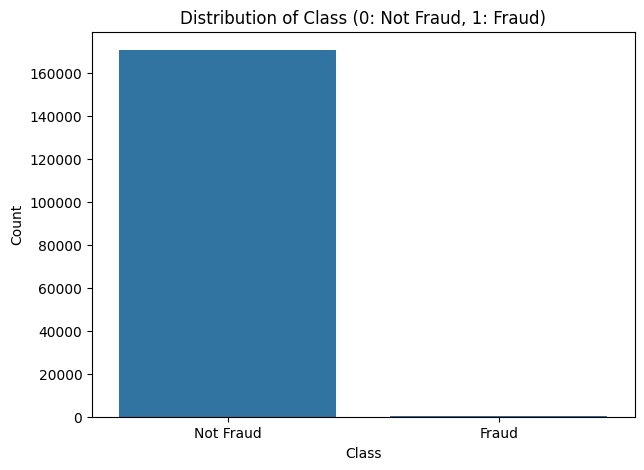

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=train_df)
plt.title('Distribution of Class (0: Not Fraud, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'])
plt.show()

### 'Amount' 컬럼 분포 및 사기 여부 시각화

'Amount' 컬럼의 통계치를 확인했고, 사기 거래와 정상 거래 모두 거래 금액이 낮은 값에 집중되어 있지만, 사기 거래의 경우 특정 금액대에서 높은 밀도를 보이는 경향이 있음을 알 수 있습니다.

count    170883.000000
mean         87.336704
std         245.954429
min           0.000000
25%           5.480000
50%          21.890000
75%          76.720000
max       19656.530000
Name: Amount, dtype: float64


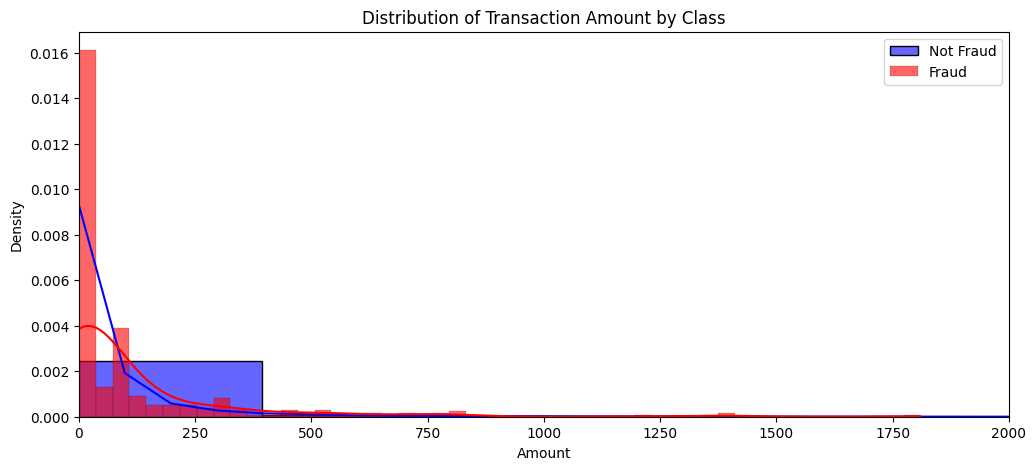

In [9]:
print(train_df['Amount'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(train_df[train_df['Class'] == 0]['Amount'], bins=50, color='blue', label='Not Fraud', kde=True, stat='density', alpha=0.6)
sns.histplot(train_df[train_df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', kde=True, stat='density', alpha=0.6)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 2000) # 대부분의 거래 금액이 낮은 값에 집중되어 있으므로 x축 범위 제한
plt.show()

### 'Time' 컬럼 분포 및 사기 여부 시각화

'Time' 컬럼의 통계치를 확인했으며, 사기 거래와 정상 거래 모두 시간 경과에 따라 특정 패턴 없이 분포하는 것을 확인할 수 있습니다. 이는 'Time' 컬럼 자체가 사기 여부를 판단하는 데 직접적인 특징으로 활용되기 어려울 수 있음을 시사합니다.

count    170883.000000
mean      61091.567090
std       27828.109419
min           0.000000
25%       41216.500000
50%       60776.000000
75%       78622.000000
max      120396.000000
Name: Time, dtype: float64


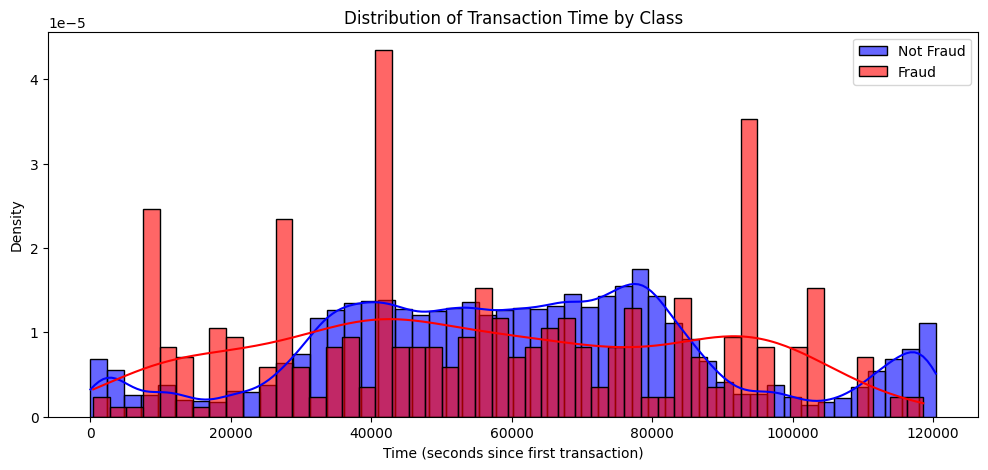

In [10]:
print(train_df['Time'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(train_df[train_df['Class'] == 0]['Time'], bins=50, color='blue', label='Not Fraud', kde=True, stat='density', alpha=0.6)
sns.histplot(train_df[train_df['Class'] == 1]['Time'], bins=50, color='red', label='Fraud', kde=True, stat='density', alpha=0.6)
plt.title('Distribution of Transaction Time by Class')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

In [12]:
X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [14]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


# 레이블 불균형 처리

In [15]:
!pip install imblearn

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 후 학습 데이터 레이블 값 분포:')
print(y_train_smote.value_counts())


SMOTE 적용 후 학습 데이터 레이블 값 분포:
Class
0    136418
1    136418
Name: count, dtype: int64


# lr with SMOTE

### Subtask:
SMOTE로 오버샘플링된 훈련 데이터를 사용하여 `LogisticRegression` 모델을 학습시키고, 원본 검증 데이터(`X_val`, `y_val`)로 성능을 평가합니다. 이때 `max_iter`를 충분히 설정하고 `solver`를 지정합니다.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 2. LogisticRegression 모델 객체 생성 (max_iter, solver, random_state 지정)
lr_clf_smote = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

# 3. 모델 학습
lr_clf_smote.fit(X_train_smote, y_train_smote)
print('SMOTE 적용 후 Logistic Regression 모델 학습 완료!')

# 4. 검증 데이터에 대한 예측
lr_val_smote = lr_clf_smote.predict(X_val)

# 5. 검증 데이터에 대한 클래스 1 예측 확률
lr_val_proba_smote = lr_clf_smote.predict_proba(X_val)[:, 1]

# 7. 평가 지표 계산
lr_val_confusion_smote = confusion_matrix(y_val, lr_val_smote)
lr_val_accuracy_smote = accuracy_score(y_val, lr_val_smote)
lr_val_precision_smote = precision_score(y_val, lr_val_smote)
lr_val_recall_smote = recall_score(y_val, lr_val_smote)
lr_val_f1_smote = f1_score(y_val, lr_val_smote)

# 8. ROC AUC 점수 계산
lr_val_roc_score_smote = roc_auc_score(y_val, lr_val_proba_smote)

# 9. 계산된 모든 평가 지표 출력
print('\nSMOTE 적용 후 검증 데이터 혼동행렬:')
print(lr_val_confusion_smote)
print(f"SMOTE 적용 후 검증 데이터 정확도: {lr_val_accuracy_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 정밀도: {lr_val_precision_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 재현율: {lr_val_recall_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 F1 점수: {lr_val_f1_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 AUC: {lr_val_roc_score_smote:.4f}")

SMOTE 적용 후 Logistic Regression 모델 학습 완료!

SMOTE 적용 후 검증 데이터 혼동행렬:
[[33458   647]
 [    6    66]]
SMOTE 적용 후 검증 데이터 정확도: 0.9809
SMOTE 적용 후 검증 데이터 정밀도: 0.0926
SMOTE 적용 후 검증 데이터 재현율: 0.9167
SMOTE 적용 후 검증 데이터 F1 점수: 0.1682
SMOTE 적용 후 검증 데이터 AUC: 0.9771


# XGBoost with SMOTE

### Subtask:
SMOTE로 오버샘플링된 훈련 데이터를 사용하여 `XGBClassifier` 모델을 학습시키고, 원본 검증 데이터(`X_val`, `y_val`)로 성능을 평가합니다. 최적의 성능을 위해 `scale_pos_weight`나 `eval_metric` 등의 파라미터를 고려할 수 있습니다.


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate scale_pos_weight for class imbalance (using original y_train)
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_val = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.2f}")

# 2. XGBClassifier 모델 객체 생성
xgb_clf_smote = XGBClassifier(
    n_estimators=1000,
    random_state=42,
    eval_metric='aucpr', # Use AUPRC for imbalanced datasets
    scale_pos_weight=scale_pos_weight_val # Handle class imbalance
)

# 3. 모델 학습
xgb_clf_smote.fit(X_train_smote, y_train_smote)
print('SMOTE 적용 후 XGBoost 모델 학습 완료!')

# 4. 검증 데이터에 대한 예측
xgb_val_pred_smote = xgb_clf_smote.predict(X_val)

# 5. 검증 데이터에 대한 클래스 1 예측 확률
xgb_val_proba_smote = xgb_clf_smote.predict_proba(X_val)[:, 1]

# 6. 평가 지표 계산
xgb_val_confusion_smote = confusion_matrix(y_val, xgb_val_pred_smote)
xgb_val_accuracy_smote = accuracy_score(y_val, xgb_val_pred_smote)
xgb_val_precision_smote = precision_score(y_val, xgb_val_pred_smote)
xgb_val_recall_smote = recall_score(y_val, xgb_val_pred_smote)
xgb_val_f1_smote = f1_score(y_val, xgb_val_pred_smote)

# 7. ROC AUC 점수 계산
xgb_val_roc_score_smote = roc_auc_score(y_val, xgb_val_proba_smote)

# 8. 계산된 모든 평가 지표 출력
print('\nSMOTE 적용 후 검증 데이터 혼동행렬:')
print(xgb_val_confusion_smote)
print(f"SMOTE 적용 후 검증 데이터 정확도: {xgb_val_accuracy_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 정밀도: {xgb_val_precision_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 재현율: {xgb_val_recall_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 F1 점수: {xgb_val_f1_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 AUC: {xgb_val_roc_score_smote:.4f}")

Calculated scale_pos_weight: 473.67
SMOTE 적용 후 XGBoost 모델 학습 완료!

SMOTE 적용 후 검증 데이터 혼동행렬:
[[34091    14]
 [    9    63]]
SMOTE 적용 후 검증 데이터 정확도: 0.9993
SMOTE 적용 후 검증 데이터 정밀도: 0.8182
SMOTE 적용 후 검증 데이터 재현율: 0.8750
SMOTE 적용 후 검증 데이터 F1 점수: 0.8456
SMOTE 적용 후 검증 데이터 AUC: 0.9663


## LightGBM with SMOTE

### Subtask:
SMOTE로 오버샘플링된 훈련 데이터를 사용하여 `LGBMClassifier` 모델을 학습시키고, 원본 검증 데이터(`X_val`, `y_val`)로 성능을 평가합니다. `is_unbalance`나 `scale_pos_weight` 등의 파라미터를 고려할 수 있습니다.


In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate scale_pos_weight for class imbalance (using original y_train)
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_val = neg_count / pos_count
print(f"Calculated scale_pos_weight for LGBM: {scale_pos_weight_val:.2f}")

# 2. LGBMClassifier 모델 객체 생성
lgbm_clf_smote = LGBMClassifier(
    n_estimators=1000,
    random_state=42,
    eval_metric='aucpr', # Use AUPRC for imbalanced datasets
    scale_pos_weight=scale_pos_weight_val # Handle class imbalance
)

# 3. 모델 학습
lgbm_clf_smote.fit(X_train_smote, y_train_smote)
print('SMOTE 적용 후 LightGBM 모델 학습 완료!')

# 4. 검증 데이터에 대한 예측
lgbm_val_pred_smote = lgbm_clf_smote.predict(X_val)

# 5. 검증 데이터에 대한 클래스 1 예측 확률
lgbm_val_proba_smote = lgbm_clf_smote.predict_proba(X_val)[:, 1]

# 6. 평가 지표 계산
lgbm_val_confusion_smote = confusion_matrix(y_val, lgbm_val_pred_smote)
lgbm_val_accuracy_smote = accuracy_score(y_val, lgbm_val_pred_smote)
lgbm_val_precision_smote = precision_score(y_val, lgbm_val_pred_smote)
lgbm_val_recall_smote = recall_score(y_val, lgbm_val_pred_smote)
lgbm_val_f1_smote = f1_score(y_val, lgbm_val_pred_smote)

# 7. ROC AUC 점수 계산
lgbm_val_roc_score_smote = roc_auc_score(y_val, lgbm_val_proba_smote)

# 8. 계산된 모든 평가 지표 출력
print('\nSMOTE 적용 후 검증 데이터 혼동행렬:')
print(lgbm_val_confusion_smote)
print(f"SMOTE 적용 후 검증 데이터 정확도: {lgbm_val_accuracy_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 정밀도: {lgbm_val_precision_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 재현율: {lgbm_val_recall_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 F1 점수: {lgbm_val_f1_smote:.4f}")
print(f"SMOTE 적용 후 검증 데이터 AUC: {lgbm_val_roc_score_smote:.4f}")

Calculated scale_pos_weight for LGBM: 473.67
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 136418, number of negative: 136418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 272836, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

## Retry LightGBM with SMOTE (Corrected Parameters)

### Subtask:
SMOTE로 오버샘플링된 훈련 데이터를 사용하여 `LGBMClassifier` 모델을 학습시키고, 원본 검증 데이터(`X_val`, `y_val`)로 성능을 평가합니다. 이전 실행에서 발생한 `eval_metric` 파라미터 경고를 수정하고, SMOTE 적용 후에는 `scale_pos_weight`를 제거하여 모델의 재현율과 정밀도를 향상시킵니다.


In [23]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 2. LGBMClassifier 모델 객체 생성 (eval_metric, scale_pos_weight 파라미터 제거)
lgbm_clf_smote_corrected = LGBMClassifier(
    n_estimators=1000,
    random_state=42
)

# 3. 모델 학습
lgbm_clf_smote_corrected.fit(X_train_smote, y_train_smote)
print('SMOTE 적용 후 LightGBM 모델 학습 완료 (수정된 파라미터)!')

# 4. 검증 데이터에 대한 예측
lgbm_val_pred_smote_corrected = lgbm_clf_smote_corrected.predict(X_val)

# 5. 검증 데이터에 대한 클래스 1 예측 확률
lgbm_val_proba_smote_corrected = lgbm_clf_smote_corrected.predict_proba(X_val)[:, 1]

# 6. 평가 지표 계산 및 출력
lgbm_val_confusion_smote_corrected = confusion_matrix(y_val, lgbm_val_pred_smote_corrected)
lgbm_val_accuracy_smote_corrected = accuracy_score(y_val, lgbm_val_pred_smote_corrected)
lgbm_val_precision_smote_corrected = precision_score(y_val, lgbm_val_pred_smote_corrected)
lgbm_val_recall_smote_corrected = recall_score(y_val, lgbm_val_pred_smote_corrected)
lgbm_val_f1_smote_corrected = f1_score(y_val, lgbm_val_pred_smote_corrected)
lgbm_val_roc_score_smote_corrected = roc_auc_score(y_val, lgbm_val_proba_smote_corrected)

print('\nSMOTE 적용 후 검증 데이터 혼동행렬 (수정된 파라미터):')
print(lgbm_val_confusion_smote_corrected)
print(f"SMOTE 적용 후 검증 데이터 정확도 (수정된 파라미터): {lgbm_val_accuracy_smote_corrected:.4f}")
print(f"SMOTE 적용 후 검증 데이터 정밀도 (수정된 파라미터): {lgbm_val_precision_smote_corrected:.4f}")
print(f"SMOTE 적용 후 검증 데이터 재현율 (수정된 파라미터): {lgbm_val_recall_smote_corrected:.4f}")
print(f"SMOTE 적용 후 검증 데이터 F1 점수 (수정된 파라미터): {lgbm_val_f1_smote_corrected:.4f}")
print(f"SMOTE 적용 후 검증 데이터 AUC (수정된 파라미터): {lgbm_val_roc_score_smote_corrected:.4f}")

[LightGBM] [Info] Number of positive: 136418, number of negative: 136418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 272836, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

## Compare Model Performance

### Subtask:
SMOTE 적용 후 로지스틱 회귀, XGBoost, LightGBM 세 모델의 성능 지표(정확도, 정밀도, 재현율, F1 점수, ROC AUC)를 비교


In [24]:
metrics = {
    'Logistic Regression_SMOTE': {
        'Accuracy': lr_val_accuracy_smote,
        'Precision': lr_val_precision_smote,
        'Recall': lr_val_recall_smote,
        'F1 Score': lr_val_f1_smote,
        'ROC AUC': lr_val_roc_score_smote
    },
    'XGBoost_SMOTE': {
        'Accuracy': xgb_val_accuracy_smote,
        'Precision': xgb_val_precision_smote,
        'Recall': xgb_val_recall_smote,
        'F1 Score': xgb_val_f1_smote,
        'ROC AUC': xgb_val_roc_score_smote
    },
    'LightGBM_SMOTE_Corrected': {
        'Accuracy': lgbm_val_accuracy_smote_corrected,
        'Precision': lgbm_val_precision_smote_corrected,
        'Recall': lgbm_val_recall_smote_corrected,
        'F1 Score': lgbm_val_f1_smote_corrected,
        'ROC AUC': lgbm_val_roc_score_smote_corrected
    }
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("\nModel Performance Comparison (SMOTE-applied models):\n")
print(metrics_df.round(4))



Model Performance Comparison (SMOTE-applied models):

                           Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression_SMOTE    0.9809     0.0926  0.9167    0.1682   0.9771
XGBoost_SMOTE                0.9993     0.8182  0.8750    0.8456   0.9663
LightGBM_SMOTE_Corrected     0.9995     0.9000  0.8750    0.8873   0.9689


## Create an Ensemble Model (VotingClassifier)

### Subtask:
이전에 학습된 Logistic Regression, XGBoost, LightGBM 모델을 사용하여 `VotingClassifier` 앙상블 모델을 생성합니다. 각 모델에 가중치를 부여하거나, 하드/소프트 보팅 방식을 선택할 수 있습니다.


In [25]:
from sklearn.ensemble import VotingClassifier

# 개별 모델 정의 (이전에 학습된 모델 재사용)
# lr_clf_smote, xgb_clf_smote, lgbm_clf_smote_corrected는 이전 셀에서 학습이 완료된 상태입니다.

# VotingClassifier 객체 생성
# 소프트 보팅 방식을 사용하며, 각 모델의 예측 확률을 평균하여 최종 예측을 수행합니다.
ensemble_clf = VotingClassifier(estimators=[
    ('lr', lr_clf_smote),
    ('xgb', xgb_clf_smote),
    ('lgbm', lgbm_clf_smote_corrected)
], voting='soft', n_jobs=-1) # n_jobs=-1로 설정하여 가능한 모든 코어를 사용하여 학습 속도 향상

print('VotingClassifier 객체 생성 완료!')

VotingClassifier 객체 생성 완료!


In [26]:
print('앙상블 모델 학습 시작...')
ensemble_clf.fit(X_train_smote, y_train_smote)
print('앙상블 모델 학습 완료!')

# 검증 데이터에 대한 예측
ensemble_val_pred = ensemble_clf.predict(X_val)

# 검증 데이터에 대한 클래스 1 예측 확률
ensemble_val_proba = ensemble_clf.predict_proba(X_val)[:, 1]

# 평가 지표 계산
ensemble_val_confusion = confusion_matrix(y_val, ensemble_val_pred)
ensemble_val_accuracy = accuracy_score(y_val, ensemble_val_pred)
ensemble_val_precision = precision_score(y_val, ensemble_val_pred)
ensemble_val_recall = recall_score(y_val, ensemble_val_pred)
ensemble_val_f1 = f1_score(y_val, ensemble_val_pred)
ensemble_val_roc_score = roc_auc_score(y_val, ensemble_val_proba)

# 계산된 모든 평가 지표 출력
print('\n앙상블 모델 검증 데이터 혼동행렬:')
print(ensemble_val_confusion)
print(f"앙상블 모델 검증 데이터 정확도: {ensemble_val_accuracy:.4f}")
print(f"앙상블 모델 검증 데이터 정밀도: {ensemble_val_precision:.4f}")
print(f"앙상블 모델 검증 데이터 재현율: {ensemble_val_recall:.4f}")
print(f"앙상블 모델 검증 데이터 F1 점수: {ensemble_val_f1:.4f}")
print(f"앙상블 모델 검증 데이터 AUC: {ensemble_val_roc_score:.4f}")

앙상블 모델 학습 시작...
앙상블 모델 학습 완료!

앙상블 모델 검증 데이터 혼동행렬:
[[34094    11]
 [    9    63]]
앙상블 모델 검증 데이터 정확도: 0.9994
앙상블 모델 검증 데이터 정밀도: 0.8514
앙상블 모델 검증 데이터 재현율: 0.8750
앙상블 모델 검증 데이터 F1 점수: 0.8630
앙상블 모델 검증 데이터 AUC: 0.9775


In [27]:
metrics['Ensemble_VotingClassifier'] = {
    'Accuracy': ensemble_val_accuracy,
    'Precision': ensemble_val_precision,
    'Recall': ensemble_val_recall,
    'F1 Score': ensemble_val_f1,
    'ROC AUC': ensemble_val_roc_score
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("\nUpdated Model Performance Comparison (SMOTE-applied models with Ensemble):\n")
print(metrics_df.round(4))


Updated Model Performance Comparison (SMOTE-applied models with Ensemble):

                           Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression_SMOTE    0.9809     0.0926  0.9167    0.1682   0.9771
XGBoost_SMOTE                0.9993     0.8182  0.8750    0.8456   0.9663
LightGBM_SMOTE_Corrected     0.9995     0.9000  0.8750    0.8873   0.9689
Ensemble_VotingClassifier    0.9994     0.8514  0.8750    0.8630   0.9775


## Hyperparameter Tuning for LightGBM

### Subtask:
`hyperopt` 라이브러리를 사용하여 `LGBMClassifier` 모델의 주요 하이퍼파라미터(`n_estimators`, `learning_rate`, `max_depth`, `num_leaves`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda` 등)에 대한 최적 값을 SMOTE로 오버샘플링된 훈련 데이터(`X_train_smote`, `y_train_smote`)에서 탐색합니다. 최적화 목표는 검증 데이터(`X_val`, `y_val`)의 ROC AUC 또는 F1 점수를 최대화하는 것으로 설정합니다.


In [2]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import time

print("Required libraries imported successfully.")

Required libraries imported successfully.


In [3]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 60, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(0.5)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(0.5))
}

print("Hyperparameter search space defined successfully.")

Hyperparameter search space defined successfully.


In [4]:
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])

    model = LGBMClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    model.fit(X_train_smote, y_train_smote)
    eval_time = time.time() - start_time

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # Hyperopt minimizes the objective, so return 1 - roc_auc to maximize roc_auc
    return {'loss': 1 - roc_auc, 'status': STATUS_OK, 'eval_time': eval_time, 'params': params}

print("Hyperopt objective function defined successfully.")

Hyperopt objective function defined successfully.


In [5]:
trials = Trials()

print("Trials object initialized successfully.")

Trials object initialized successfully.


# Task
하이퍼파라미터 튜닝을 통해 최적화된 LightGBM 모델의 성능을 평가하고, 튜닝 전 LightGBM 모델 및 다른 모델들과의 성능을 비교합니다. 이 과정에서 `hyperopt`의 `objective` 함수가 `X_train_smote`, `y_train_smote`, `X_val`, `y_val` 데이터를 인자로 직접 받아 `NameError`를 해결하고, `functools.partial`을 사용하여 `fmin`에 함수와 데이터를 전달합니다.

In [8]:
def objective(params, X_train, y_train, X_val, y_val):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])

    model = LGBMClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    model.fit(X_train, y_train)
    eval_time = time.time() - start_time

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    return {'loss': 1 - roc_auc, 'status': STATUS_OK, 'eval_time': eval_time, 'params': params}

print("Hyperopt objective function redefined to accept data as arguments.")

Hyperopt objective function redefined to accept data as arguments.


# Task
하이퍼파라미터 튜닝을 통해 LightGBM 모델의 성능을 최적화합니다. 이를 위해 `hyperopt` 라이브러리를 사용하여 `LGBMClassifier`의 하이퍼파라미터(`n_estimators`, `learning_rate`, `max_depth`, `num_leaves`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`)를 `X_train_smote`, `y_train_smote` 데이터로 학습하고 `X_val`, `y_val` 데이터의 ROC AUC 점수를 최대화하도록 탐색합니다. `max_evals`를 50으로 설정하고, 최적화된 모델의 혼동 행렬, 정확도, 정밀도, 재현율, F1 점수, ROC AUC를 계산하여 출력합니다. 최종적으로 튜닝 전 LightGBM 모델 및 다른 모델들과의 성능을 비교 분석하고 개선점을 요약합니다.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Re-load train_df as it might have been cleared
train_df = pd.read_csv('/content/train.csv')

# Recreate train_copy by dropping 'Time' column
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

# Recreate X_features and y_target
X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

# Recreate train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

# Reapply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("All data preparation steps (train_df, train_copy, X_features, y_target, X_train, X_val, y_train, y_val, X_train_smote, y_train_smote) re-executed successfully.")

All data preparation steps (train_df, train_copy, X_features, y_target, X_train, X_val, y_train, y_val, X_train_smote, y_train_smote) re-executed successfully.


In [ ]:
import functools
from hyperopt import fmin, tpe
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Create a partial function to pass the data to the objective function
objective_with_data = functools.partial(objective,
                                        X_train=X_train_smote,
                                        y_train=y_train_smote,
                                        X_val=X_val,
                                        y_val=y_val)

# Run the hyperparameter optimization
print('Starting hyperparameter optimization...')

# Re-initialize trials to avoid issues from previous failed attempts
trials = Trials()

best_params = fmin(
    fn=objective_with_data,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20, # Set max_evals to 50 as per the subtask instruction
    trials=trials,
    rstate=np.random.default_rng(42) # For reproducibility
)

print('\nHyperparameter optimization completed!')
print(f"Best parameters found: {best_params}")

# Convert best_params to the format expected by LGBMClassifier
optimized_n_estimators = int(best_params['n_estimators'])
optimized_max_depth = int(best_params['max_depth'])
optimized_num_leaves = int(best_params['num_leaves'])

# Train the LGBMClassifier with the best parameters
optimized_lgbm_clf = LGBMClassifier(
    n_estimators=optimized_n_estimators,
    learning_rate=best_params['learning_rate'],
    max_depth=optimized_max_depth,
    num_leaves=optimized_num_leaves,
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    n_jobs=-1
)

print('\nTraining LightGBM with optimized parameters...')
optimized_lgbm_clf.fit(X_train_smote, y_train_smote)
print('LightGBM with optimized parameters trained!')

# Evaluate the optimized model on the validation data
optimized_lgbm_val_pred = optimized_lgbm_clf.predict(X_val)
optimized_lgbm_val_proba = optimized_lgbm_clf.predict_proba(X_val)[:, 1]

optimized_lgbm_val_confusion = confusion_matrix(y_val, optimized_lgbm_val_pred)
optimized_lgbm_val_accuracy = accuracy_score(y_val, optimized_lgbm_val_pred)
optimized_lgbm_val_precision = precision_score(y_val, optimized_lgbm_val_pred)
optimized_lgbm_val_recall = recall_score(y_val, optimized_lgbm_val_pred)
optimized_lgbm_val_f1 = f1_score(y_val, optimized_lgbm_val_pred)
optimized_lgbm_val_roc_score = roc_auc_score(y_val, optimized_lgbm_val_proba)

print('\nOptimized LightGBM Model Performance on Validation Data:')
print(optimized_lgbm_val_confusion)
print(f"Accuracy: {optimized_lgbm_val_accuracy:.4f}")
print(f"Precision: {optimized_lgbm_val_precision:.4f}")
print(f"Recall: {optimized_lgbm_val_recall:.4f}")
print(f"F1 Score: {optimized_lgbm_val_f1:.4f}")
print(f"ROC AUC: {optimized_lgbm_val_roc_score:.4f}")